In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from vnstock import *

from Tools.function import *
from Tools.operators import *
from Tools.technical import *

from Fundamental.fndl import *

##### VN30

In [2]:
close = pd.read_csv("Data/close.csv", index_col="TradingDate", parse_dates=True)
high = pd.read_csv("Data/high.csv", index_col="TradingDate", parse_dates=True)
low = pd.read_csv("Data/low.csv", index_col="TradingDate", parse_dates=True)
open = pd.read_csv("Data/open.csv", index_col="TradingDate", parse_dates=True)
volume = pd.read_csv("Data/volume.csv", index_col="TradingDate", parse_dates=True)
returns = close.pct_change()

### Fundamental

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness         Margin
0  0.028555  0.304958   0.00017  0.145756  167978.185032
Overall of neutralize
     Return    Sharpe  Turnover   Fitness         Margin
0 -0.031073 -0.386628  0.000199 -0.192766 -155860.300682


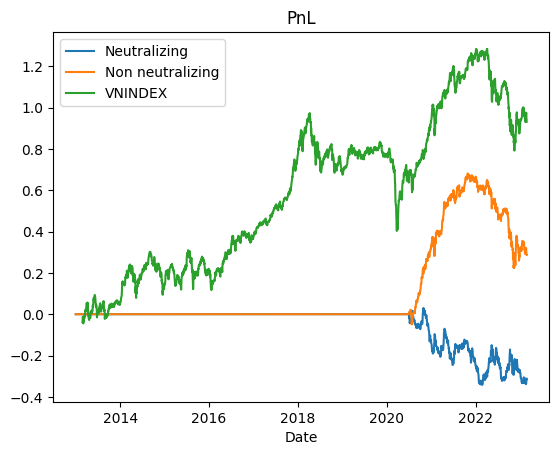

In [3]:
a= Stimulate(fndl("inventory"))
a.plot_pnl()
a.overall()

In [4]:
a.get_weights()

VIC    0.200000
HPG    0.182967
MWG    0.123533
MSN    0.050547
PDR    0.035043
VNM   -0.007334
GAS   -0.016379
FPT   -0.029901
BVH   -0.042208
TPB   -0.043056
VCB   -0.043056
VHM   -0.043056
ACB   -0.043056
VIB   -0.043056
STB   -0.043056
VJC   -0.043056
VPB   -0.043056
TCB   -0.043056
PLX   -0.043056
SSI   -0.043056
SAB   -0.043056
POW   -0.043056
BCM   -0.043056
NVL   -0.043056
MBB   -0.043056
HDB   -0.043056
GVR   -0.043056
CTG   -0.043056
BID   -0.043056
VRE   -0.043056
Name: 2023-02-24 00:00:00, dtype: float64


In [5]:
a= Stimulate(rank(fndl("asset")/fndl("inventory")))

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness        Margin
0  0.076893  0.532731  0.000038  0.417828  2.014754e+06
Overall of neutralize
     Return    Sharpe  Turnover   Fitness         Margin
0  0.043054  0.410454  0.000148  0.240888  290082.608124


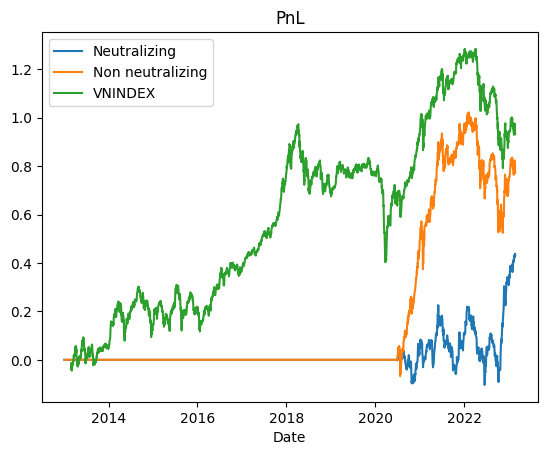

In [6]:
a.plot_pnl()
a.overall()

### Prob weight model

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.166213  1.423933  0.960734  0.592271  173.006253
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.280336  1.855702  2.178162  0.665736  128.702814


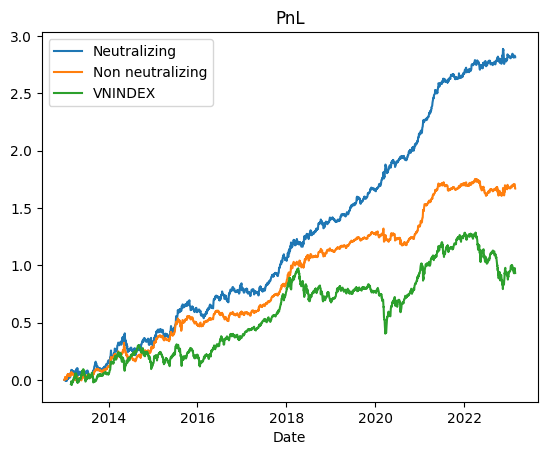

In [7]:
prob = prob_weights(volume,5)
kq = Stimulate(prob)
kq.plot_pnl()
kq.overall()

### Markowitz model

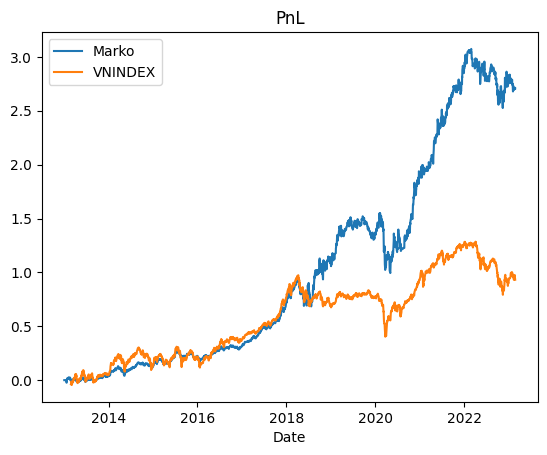

In [8]:
mark = marko_weights(close,lag=10)
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

### volum/adv20

Overall of non neutralize
     Return   Sharpe  Turnover  Fitness      Margin
0  0.288089  1.40553  0.389027  1.20952  740.535142
Overall of neutralize
    Return    Sharpe  Turnover   Fitness      Margin
0  0.36566  2.257082  1.403626  1.152021  260.510976


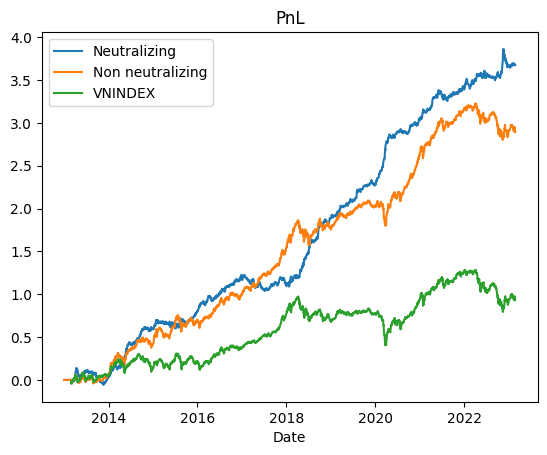

In [9]:
alpha1 =volume/ts_mean(ts_decay_linear(volume,30),20)
kq1 = Stimulate(alpha1)
kq1.plot_pnl()
kq1.overall()

##### MAE

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.283339  1.373531  0.418479  1.130199  677.069188
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.433865  2.766211  1.571532  1.453453  276.077522


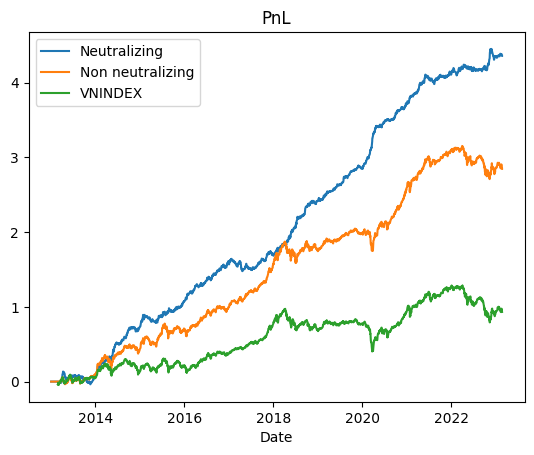

In [10]:
alpha2 = rank(mae(alpha1))
kq2 = Stimulate(alpha2)
kq2.plot_pnl()
kq2.overall()

##### MACD hist

Overall of non neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.287601  1.404875  0.401823  1.188544  715.740411
Overall of neutralize
     Return    Sharpe  Turnover   Fitness      Margin
0  0.447961  2.868373  1.508682  1.562993  296.922155


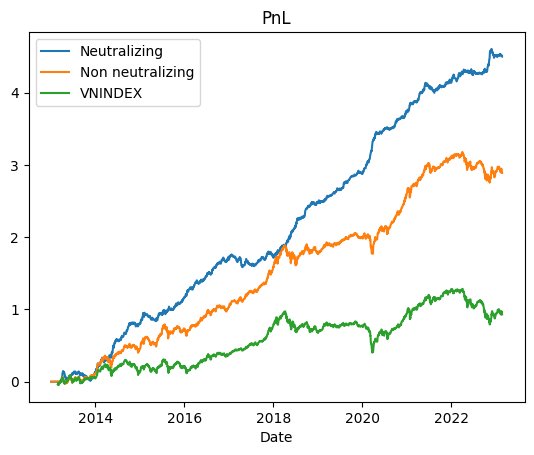

In [11]:
alpha3 = rank(macd_his(alpha1))
kq3 = Stimulate(alpha3)
kq3.plot_pnl()
kq3.overall()

##### Save weight

In [12]:
kq3.get_weights()

VJC    0.128889
VHM    0.120000
VNM    0.111111
VIC    0.102222
MBB    0.093333
MSN    0.084444
VRE    0.075556
BCM    0.066667
ACB    0.057778
PLX    0.048889
HDB    0.040000
MWG    0.031111
SAB    0.022222
FPT    0.013333
CTG    0.004444
NVL   -0.004444
HPG   -0.013333
POW   -0.022222
GAS   -0.031111
VCB   -0.040000
SSI   -0.048889
STB   -0.057778
BVH   -0.066667
TCB   -0.075556
VPB   -0.084444
GVR   -0.093333
VIB   -0.102222
TPB   -0.111111
BID   -0.120000
PDR   -0.128889
Name: 2023-02-24 00:00:00, dtype: float64


In [ ]:
save_weights(kq3.neu,"2023-02-24")